<h1>Predictive Model LCSF1: Lung Cancer Survival Forecasting for 1 Year</h1>


<h4>Workflow</h4><br>
<p>Here we lay out our thought process and what we did, while building a predictive model for lung cancer survival.</p>
<p></p>
<p>First we assume, that we have a choice of including a selection of more and / or less frequent </p>
<p></p>

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import networkx as nx
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

frequencySelectionApplied = 0    # 0 = do not apply, 1 = do apply

#selecting the standart dataset with no pre-selections
data = pd.read_csv("data/synthetic_data_lung_cancer.csv")

#if frequency selection has been done:
if frequencySelectionApplied == 1:
    data = pd.read_csv("data/bestFrequencyFiltered_t-low-0.3_t-high-1.csv") # adjust this import to match the result from the frequency_selection_jan notebook

print(data.columns)
data.tail()

Index(['SUBJECT_ID', 'DEFINITION_ID', 'TIME'], dtype='object')


,SUBJECT_ID,DEFINITION_ID,TIME
560966,984,measurement_1141,0.027321
560967,984,observation_156,0.028739
560968,984,measurement_1140,0.030802
560969,984,measurement_1327,0.035081
560970,984,condition_459,0.038022


Here we checked some data qualities and gained a better understanding of the data.<br>
A significant amount of this work has unfortunately been lost, but there is the Visual_Exploratory.ipynb where some graphs are retained.

In [2]:
data.loc[data['DEFINITION_ID'].str.contains('condition_*')]
#all condition observations are removed due to frequency Filtering

,SUBJECT_ID,DEFINITION_ID,TIME
1,1,condition_1922,0.008643
2,1,condition_785,0.027792
5,1,condition_1561,0.057292
7,1,condition_2391,0.065500
8,1,condition_175,0.166536
...,...,...,...
560922,984,condition_747,0.006456
560923,984,condition_1767,0.007445
560931,984,condition_517,0.008754
560964,984,condition_1496,0.023802


As a result we discovered that the frequency of DEFENITION_IDs corresponded to the types of DEFENITION_IDs. <br>
This meant that frequency selection is not useful in reducing recurrent data and noise. <br>
Therefore we concluded that maybe the recurrance of types of DEFENITION_IDs may have to be adjusted to have a fair comparison on the influence over the target feature.

Going further we decided to stretch out the DEFENITION_ID into multiple features.<br>
Both options for processing the data deliver the same final table with the difference being that the data format 0 has a seperate column for the actual IDs of the features [condition,procedure,drug,observation,measurement].

In [3]:
dataFormat = 0 # 0 for seperate ID column 1 for not
df = data.copy()
if dataFormat == 0:
    label_encoder = LabelEncoder()
    df['DEFINITION_ID_encoded'] = label_encoder.fit_transform(df['DEFINITION_ID'])
    df['condition'] = df['DEFINITION_ID'].apply(lambda x: 'condition' in x)
    df['procedure'] = df['DEFINITION_ID'].apply(lambda x: 'procedure' in x)
    df['drug'] = df['DEFINITION_ID'].apply(lambda x: 'drug' in x)
    df['observation'] = df['DEFINITION_ID'].apply(lambda x: 'observation' in x)
    df['measurement'] = df['DEFINITION_ID'].apply(lambda x: 'measurement' in x)
    df.drop(columns=['DEFINITION_ID'], inplace=True)
    df['time_since_last'] = df.groupby('SUBJECT_ID')['TIME'].diff().fillna(0)
    columns_to_convert = ['condition', 'procedure', 'drug', 'observation', 'measurement']
    for column in columns_to_convert:
        df[column] = df[column].astype(int)
    time_threshold = 1 
    df['death'] = df['time_since_last'].apply(lambda x: 1 if x <= time_threshold else 0)
elif dataFormat == 1:
    # Splitting 'DEFINITION_ID' into multiple columns
    new_cols = df['DEFINITION_ID'].str.split('_', expand=True)
    # Naming the new columns
    new_cols.columns = ['CATEGORY', 'CATEGORY_ID']
    print("New unique categorie: "+new_cols['CATEGORY'].unique())
    # Pivoting the DataFrame
    pivot_new_cols = new_cols.pivot_table(index=data.index, columns='CATEGORY', values='CATEGORY_ID', aggfunc=lambda x: ', '.join(str(v) for v in x)).fillna('-1')
    # Concatenating the new columns to the original DataFrame
    df = pd.concat([df, pivot_new_cols], axis=1)
    # Dropping the original 'DEFINITION_ID' column
    df.drop(columns=['DEFINITION_ID'], inplace=True)
    # Filling the death column 
    df['death'] = df['death'].replace('None', '1')
    df['death'] = df['death'].replace('-1', '0')
    # Converting column to boolean dtype
    df['death'] = df['death'].astype(int)
    # Creating additional column
    df['time_since_last'] = df.groupby('SUBJECT_ID')['TIME'].diff().fillna(0)
else:
    ...

print(df.columns)
#df.loc[(df['condition']=='')&(df['drug']=='')&(df['measurement']=='')&(df['observation']=='')&(df['procedure']=='')]
[print("Unique values in feature "+x+": "+str(len(df[x].unique()))) for x in df.columns]

df.head()

Index(['SUBJECT_ID', 'TIME', 'DEFINITION_ID_encoded', 'condition', 'procedure',
       'drug', 'observation', 'measurement', 'time_since_last', 'death'],
      dtype='object')
Unique values in feature SUBJECT_ID: 727
Unique values in feature TIME: 560956
Unique values in feature DEFINITION_ID_encoded: 4864
Unique values in feature condition: 2
Unique values in feature procedure: 2
Unique values in feature drug: 2
Unique values in feature observation: 2
Unique values in feature measurement: 2
Unique values in feature time_since_last: 560198
Unique values in feature death: 2


,SUBJECT_ID,TIME,DEFINITION_ID_encoded,condition,procedure,drug,observation,measurement,time_since_last,death
0,1,0.004807,2531,0,0,1,0,0,0.000000,1
1,1,0.008643,1026,1,0,0,0,0,0.003836,1
2,1,0.027792,2161,1,0,0,0,0,0.019149,1
3,1,0.032515,2762,0,0,1,0,0,0.004722,1
4,1,0.056765,3175,0,0,0,0,1,0.024250,1


Here we also included a inversion of the target feature, because we initially thought that in this way we can predict if someone will not die in one year. (This is of course wrong)

In [25]:
targetFeatureInversion = 1

if targetFeatureInversion == 1:
    df['death']=df['death'].map(lambda a:0 if a==1 else 1)
df.head()

,SUBJECT_ID,TIME,DEFINITION_ID_encoded,condition,procedure,drug,observation,measurement,time_since_last,death
0,1,0.004807,2531,0,0,1,0,0,0.000000,0
1,1,0.008643,1026,1,0,0,0,0,0.003836,0
2,1,0.027792,2161,1,0,0,0,0,0.019149,0
3,1,0.032515,2762,0,0,1,0,0,0.004722,0
4,1,0.056765,3175,0,0,0,0,1,0.024250,0


Here we included the option to make all the categorical columns resulting from DEFINITION_ID one hot encoded. This of course means that we get around 54.000 columns. This usually blows any calculations, feature selections, fitting and so on out of proportion. Hence we advise not to use it. 

In [4]:
#dummies for categorical analysis

createDummies = 0 # 0 = no, 1 = yes

if createDummies ==1 and dataFormat==1:
    df = pd.get_dummies(df,columns=['condition','drug','measurement','observation','procedure'])
    
df.head()

,SUBJECT_ID,TIME,DEFINITION_ID_encoded,condition,procedure,drug,observation,measurement,time_since_last,death
0,1,0.004807,2531,0,0,1,0,0,0.000000,1
1,1,0.008643,1026,1,0,0,0,0,0.003836,1
2,1,0.027792,2161,1,0,0,0,0,0.019149,1
3,1,0.032515,2762,0,0,1,0,0,0.004722,1
4,1,0.056765,3175,0,0,0,0,1,0.024250,1


Next we split the data into training and test data. This should be done along the SUBJECT_ID, because obviously a real world data set would only include the DEFINITION_IDs of one individual.

In [5]:
from sklearn.model_selection import train_test_split

# List of unique SUBJECT_IDs
unique_subject_ids = df['SUBJECT_ID'].unique()

# Split the unique_subject_ids into train and test IDs
train_ids, test_ids = train_test_split(unique_subject_ids, test_size=0.3, random_state=2)

# Filter the main DataFrame into train and test sets based on the selected IDs
train_data = df[df['SUBJECT_ID'].isin(train_ids)]
test_data = df[df['SUBJECT_ID'].isin(test_ids)]

# Separate the features (X) and target variable (y) for train and test sets
X_train = train_data.drop('death',axis=1)# Drop 'SUBJECT_ID' and target column
y_train = pd.Series(train_data.death)

X_test = test_data.drop('death',axis=1)# Drop 'SUBJECT_ID' and target column
y_test = pd.Series(test_data.death)

if createDummies ==1 and dataFormat==1: # Here we have to account for nonsensical values
    X_train = X_train.drop(['condition_-1','drug_-1','measurement_-1','observation_-1','procedure_-1'],axis=1)
    X_test = X_test.drop(['condition_-1','drug_-1','measurement_-1','observation_-1','procedure_-1'],axis=1)
#old way:
#X = df.drop('death',axis=1).drop(['condition_-1','drug_-1','measurement_-1','observation_-1','procedure_-1'],axis=1)
#y = pd.Series(df.death)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

print(y_train.head())
X_train.head()

0    1
1    1
2    1
3    1
4    1
Name: death, dtype: int64


,SUBJECT_ID,TIME,DEFINITION_ID_encoded,condition,procedure,drug,observation,measurement,time_since_last
0,1,0.004807,2531,0,0,1,0,0,0.000000
1,1,0.008643,1026,1,0,0,0,0,0.003836
2,1,0.027792,2161,1,0,0,0,0,0.019149
3,1,0.032515,2762,0,0,1,0,0,0.004722
4,1,0.056765,3175,0,0,0,0,1,0.024250


In [6]:
#undersampling

from sklearn.utils import resample

useUnderSampeling = 0 # 0 = no, 1 = yes

if useUnderSampeling == 1:
    # Separate majority and minority classes
    df_majority = df[df.death==0]
    df_minority = df[df.death==1]
    
    # Downsample majority class
    df_majority_downsampled = resample(df_majority,
                                     replace=False,    # sample without replacement
                                     n_samples=len(df_minority), # to match minority class
                                     random_state=123) # reproducible results
    
    # Combine minority class with downsampled majority class
    df_balanced = pd.concat([df_majority_downsampled, df_minority])
    
    # Display new class counts
    print(df_balanced.death.value_counts())
    print([len(df_balanced.loc[df_balanced['death']==1]),len(df_balanced.loc[df_balanced['death']==0, 'SUBJECT_ID'].unique())])
    
    # Separate X_train and y_train after balancing
    X_train_balanced = df_balanced.drop('death', axis=1)
    y_train_balanced = df_balanced['death']
    X_train = X_train_balanced
    y_train = y_train_balanced
else:
    print("Nothing happened")

Nothing happened


In [7]:
#feature selection

from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression  # Replace with an appropriate estimator
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest, f_classif
from scipy.sparse import csr_matrix


if createDummies==1:

#X_train_sparse = csr_matrix(X_train)

    # Initialize your estimator 
    lr=LogisticRegression(penalty='l1',solver='liblinear')
    svc=SVC(kernel="linear")
    nb=GaussianNB()
    
    estimator = lr  #change to whatever works best
    
    # Initialize RFECV with the estimator and scoring method
    rfecv=RFECV(estimator=estimator, cv=5)
    kbest=SelectKBest(score_func=f_classif, k=1000)
    selector = kbest
    
    # Fit the selector on your training data
    X_train_selected = selector.fit_transform(X_train, y_train)
    # Get selected feature indices
    selected_feature_indices = selector.get_support(indices=True)
    
    # Get the names of selected features
    selected_feature_names = X_train.columns[selected_feature_indices]
    
    # Create DataFrame with selected features
    X_train_selected_df = X_train[selected_feature_names]
    
    print(X_train_selected_df.head())
else:
    print("No feature selection, because of low feature count")

No feature selection, because of low feature count


In [8]:
# no scaling necessary

In [9]:
from prince import MCA
from sklearn.decomposition import PCA
#pip install prince

#applying MCA,PCA or others

def applyDimensionalityReduction(reductionTargetTrain,reductionTargetTest,typeOfReduction,n_components):
    if typeOfReduction == 'mca':
        X_train_categorical = reductionTargetTrain.drop(columns=['TIME','time_since_last'], inplace=False)
        X_test_categorical = reductionTargetTest.drop(columns=['TIME','time_since_last'], inplace=False)
        reducer = MCA(n_components=n_components)
        reducer.fit(X_train_categorical)
        transformed_train = reducer.transform(X_train_categorical)
        transformed_test = reducer.transform(X_test_categorical)
        X_train_mca = pd.concat([reductionTarget[['TIME','time_since_last']],transformed_train],axis=1)
        X_test_mca = pd.concat([reductionTarget[['TIME','time_since_last']],transformed_test],axis=1)
        return X_train_mca,X_test_mca
    elif typeOfReduction =='pca':
        reductionTargetTrain.columns = reductionTargetTrain.columns.astype(str)
        reductionTargetTest.columns = reductionTargetTest.columns.astype(str)
        reducer = PCA(n_components=n_components)
        reducer.fit(reductionTargetTrain)
        transformed_train = reducer.transform(reductionTargetTrain)
        transformed_test = reducer.transform(reductionTargetTest)
        return pd.DataFrame(transformed_train), pd.DataFrame(transformed_test)
    else:
        return X_train,X_test

In [10]:
X_train_reduced,X_test_reduced = applyDimensionalityReduction(X_train,X_test,'None',4) # choose 'mca','pca' or 'None'

if 1:
    X_train = X_train_reduced
    X_test = X_test_reduced
X_train.head()

,SUBJECT_ID,TIME,DEFINITION_ID_encoded,condition,procedure,drug,observation,measurement,time_since_last
0,1,0.004807,2531,0,0,1,0,0,0.000000
1,1,0.008643,1026,1,0,0,0,0,0.003836
2,1,0.027792,2161,1,0,0,0,0,0.019149
3,1,0.032515,2762,0,0,1,0,0,0.004722
4,1,0.056765,3175,0,0,0,0,1,0.024250


In [17]:
#!pip install lightgbm
!pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/bc/43/242432efc3f60052a4a534dc4926b21e236ab4ec8d4920c593da3f65c65d/xgboost-2.0.2-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB 660.6 kB/s eta 0:02:31
   ---------------------------------------- 0.0/99.8 MB 495.5 kB/s eta 0:03:22
   ---------------------------------------- 0.0/99.8 MB 495.5 kB/s eta 0:03:22
   ---------------------------------------- 0.0/99.8 MB 495.5 kB/s eta 0:03:22
   ---------------------------------------- 0.0/99.8 MB 495.5 kB/s eta 0:03:22
   ---------------------------------------- 0.1/99.8 MB 193.2 kB/s eta 0:08:36
   ---------------------------------------- 0.1/99.8 MB 249.8 kB/s eta 0:06:40
   ---------------------------------------- 0.1/99.8 MB 300.4 kB/s eta 0:05:32
   --------------------

DEPRECATION: Loading egg at c:\users\janp3\anaconda3\envs\introductiontodatascience\lib\site-packages\apyori-1.1.2-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..


In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import lightgbm as lgb
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

gSearch = 1
grid_search = None
#Grid searches:
if gSearch == 1:
    #grid search for XGB
    xgb_model = XGBClassifier(random_state=42)
    param_grid = {
        'max_depth': [3, 4, 5],
        'learning_rate': [0.1, 0.01, 0.05],
        'n_estimators': [100, 200, 300],
        'subsample': [0.8, 0.9, 1],
        'colsample_bytree': [0.3, 0.7, 1]
    }
    grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='roc_auc', cv=3, verbose=2)
    grid_search.fit(X_train, y_train)
else:
    ...

# model
lgbm = lgb.LGBMClassifier(random_state=42)
rf = RandomForestClassifier(n_estimators=50,criterion="gini",max_features=100,max_depth=4)
ada_boost_classifier = AdaBoostClassifier(base_estimator=rf, n_estimators=50, random_state=42)
svc = SVC(kernel="linear", probability=True)
xgb = grid_search.best_estimator_ if gSearch == 1 else XGBClassifier(random_state=42)
model = xgb # select desired model

#fit model
model.fit(X_train,y_train)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.9; total time=   0.5s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.9; total time=   0.5s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.9; total time=   0.5s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1; total time=   0.3s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1; total time=   0.3s
[CV] END colsample_by

[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.8; total time=   1.5s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.8; total time=   1.5s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.8; total time=   1.5s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.9; total time=   1.5s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.9; total time=   1.4s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.9; total time=   1.4s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=1; total time=   1.0s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=1; total time=   0.9s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=5, n_estimators=300, sub

[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.9; total time=   0.8s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.9; total time=   0.8s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.9; total time=   0.8s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1; total time=   0.5s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1; total time=   0.5s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=5, n_estimators

[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.9; total time=   0.5s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.9; total time=   0.5s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.9; total time=   0.5s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=1; total time=   0.3s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=1; total time=   0.3s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=5, n_estimators

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, n_estimators=300, subsample=0.8; total time=   1.6s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, n_estimators=300, subsample=0.8; total time=   1.6s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, n_estimators=300, subsample=0.8; total time=   1.7s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, n_estimators=300, subsample=0.9; total time=   1.7s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, n_estimators=300, subsample=0.9; total time=   1.7s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, n_estimators=300, subsample=0.9; total time=   1.6s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, n_estimators=300, subsample=1; total time=   1.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, n_estimators=300, subsample=1; total time=   1.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, n_estimators=300, sub

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, n_estimators=200, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, n_estimators=200, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, n_estimators=200, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, n_estimators=200, subsample=0.9; total time=   0.9s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, n_estimators=200, subsample=0.9; total time=   1.0s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, n_estimators=200, subsample=0.9; total time=   1.0s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, n_estimators=200, subsample=1; total time=   0.6s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, n_estimators=200, subsample=1; total time=   0.5s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, n_estimators

[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=4, n_estimators=100, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=4, n_estimators=100, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=4, n_estimators=100, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=4, n_estimators=100, subsample=0.9; total time=   0.6s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=4, n_estimators=100, subsample=0.9; total time=   0.5s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=4, n_estimators=100, subsample=0.9; total time=   0.5s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=4, n_estimators=100, subsample=1; total time=   0.4s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=4, n_estimators=100, subsample=1; total time=   0.4s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=4, n_estimators

[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.8; total time=   1.6s
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.8; total time=   1.6s
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.8; total time=   1.6s
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.9; total time=   1.7s
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.9; total time=   1.8s
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.9; total time=   1.7s
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=1; total time=   1.0s
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=1; total time=   1.0s
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=1; total ti

[CV] END colsample_bytree=1, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=1, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=1, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.9; total time=   1.0s
[CV] END colsample_bytree=1, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.9; total time=   1.0s
[CV] END colsample_bytree=1, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.9; total time=   1.0s
[CV] END colsample_bytree=1, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1; total time=   0.6s
[CV] END colsample_bytree=1, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1; total time=   0.6s
[CV] END colsample_bytree=1, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1; total time=   0.6s
[CV] END colsample_bytree=1, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.8;

[CV] END colsample_bytree=1, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=1, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.9; total time=   0.5s
[CV] END colsample_bytree=1, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.9; total time=   0.5s
[CV] END colsample_bytree=1, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.9; total time=   0.5s
[CV] END colsample_bytree=1, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=1; total time=   0.3s
[CV] END colsample_bytree=1, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=1; total time=   0.3s
[CV] END colsample_bytree=1, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=1; total time=   0.3s
[CV] END colsample_bytree=1, learning_rate=0.05, max_depth=3, n_estimators=200, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1, learning_rate=0.05, max_depth=3, n_estimators=200, subsample=0.8;

[CV] END colsample_bytree=1, learning_rate=0.05, max_depth=5, n_estimators=300, subsample=0.9; total time=   1.8s
[CV] END colsample_bytree=1, learning_rate=0.05, max_depth=5, n_estimators=300, subsample=0.9; total time=   1.7s
[CV] END colsample_bytree=1, learning_rate=0.05, max_depth=5, n_estimators=300, subsample=0.9; total time=   1.6s
[CV] END colsample_bytree=1, learning_rate=0.05, max_depth=5, n_estimators=300, subsample=1; total time=   1.0s
[CV] END colsample_bytree=1, learning_rate=0.05, max_depth=5, n_estimators=300, subsample=1; total time=   1.0s
[CV] END colsample_bytree=1, learning_rate=0.05, max_depth=5, n_estimators=300, subsample=1; total time=   1.1s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

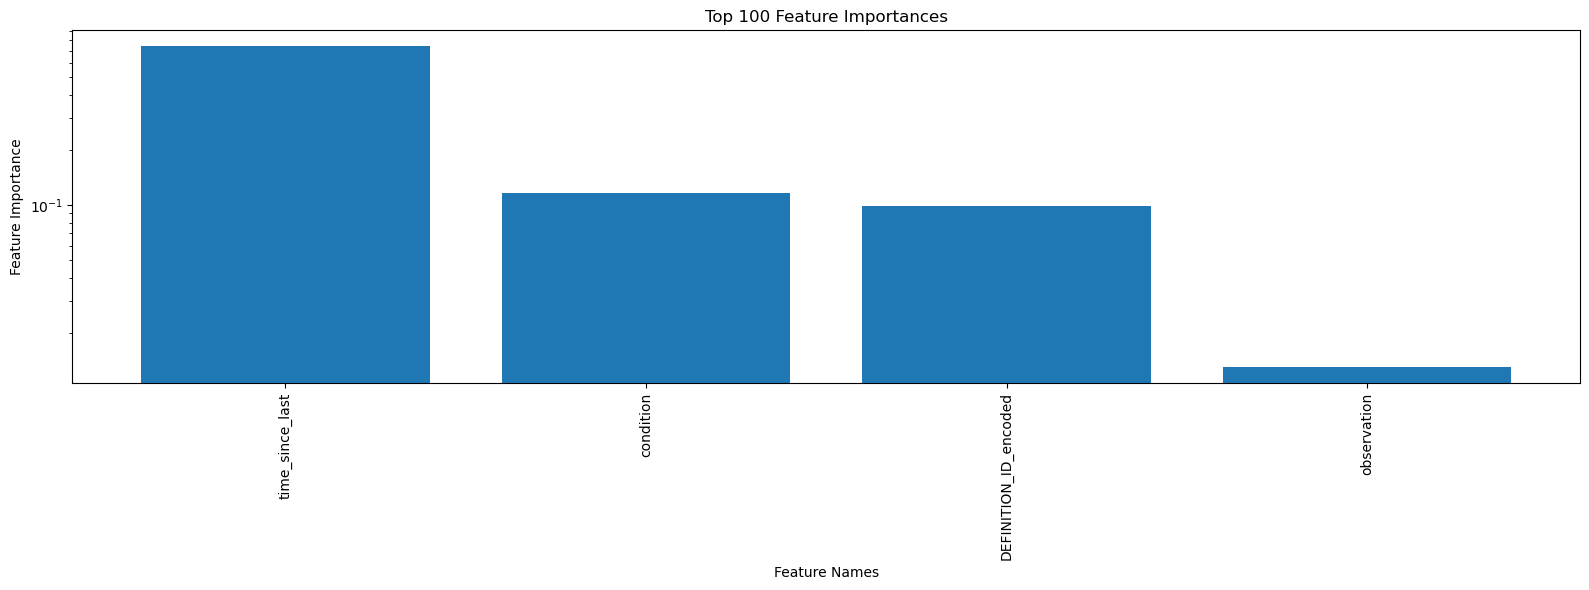

In [19]:
import numpy as np
import matplotlib.pyplot as plt


# Get feature importances
feature_importances = model.feature_importances_
feature_names = X_train.columns

# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

# Limit the number of features to display (top 100)
top_n = 4
indices = indices[:top_n]
feature_importances = feature_importances[indices]
feature_names = feature_names[indices]

# Plot feature importances (top 100)
plt.figure(figsize=(16, 6))
plt.title("Top 100 Feature Importances")
plt.bar(range(top_n), feature_importances, align="center")
plt.xticks(range(top_n), feature_names, rotation=90)
plt.xlabel("Feature Names")
plt.ylabel("Feature Importance")
plt.yscale('log')
plt.tight_layout()
plt.show()

In [20]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

cv = KFold(n_splits=5)#, shuffle=True, random_state=42

#cross validation
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc')
print(scores)
print()

[0.99958308 0.99954365 0.99978929 0.9992435  0.99957624]



In [21]:
#predict probabilities
probs = model.predict_proba(X_test)
probs = pd.DataFrame(probs)
y_pred_proba = pd.Series(probs.iloc[:, 1])

# Calculate AUC
auc = roc_auc_score(y_test.values, y_pred_proba)
print("AUC:", auc)

AUC: 0.9995274276804313


ROC AUC Score: 1.00


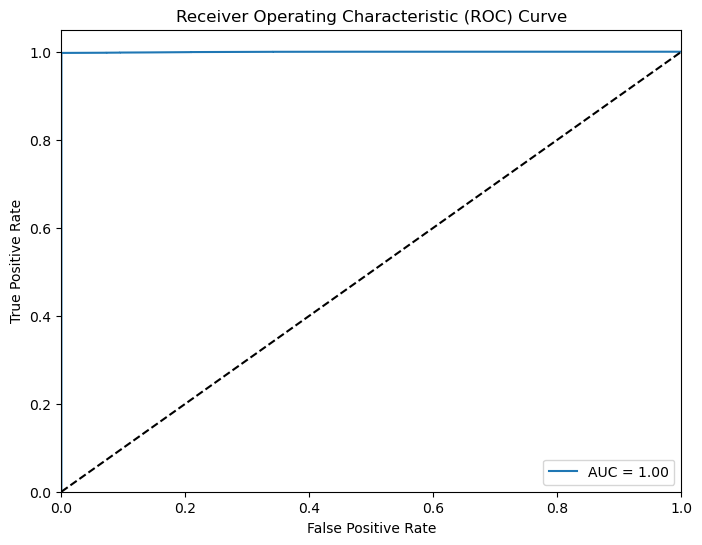

In [22]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

print(f"ROC AUC Score: {auc:.2f}")
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Tools used:<br>
- ChatGPT (this is due to our inexperience with complex python data processing, model training and plotting)<br>

Sources used: